## 3D benchmark
To test the applicability of the developed pipeline, we create 3D Ackley function as follows: 

$$
f_{3D}(x,y,z)  = -a \exp\left(-b \sqrt{\frac{x^2 + y^2 + z^2}{3}}\right) - \exp\left(\frac{\cos(cx) + \cos(cy) + \cos(cz)}{3}\right) + a + \exp(1)
$$

on $x,y,z:[-5,5]\times [-5,5]\times [-5,5]$. The interval is discretized into 200$\times$200$\times$200 points and we assumed that no data are available for $x,y,z:[-0.5,-0.5]\times [-0.5,0.5]\times [-0.5,0.5] \cup [-0.5,0.5]\times[2.0,3.0]\times [-0.5,0.5] \cup [2,3]\times [2,3] \times [-0.5,0.5]\cup [-0.5,0.5]\times [-0.5,0.5] \times [2.0,3.0] $.  Then we use the devloepd pipeline to fit Fourier based functions on this masked data and reconstruct the whole data from it. 

### create test function (Ackley function)

In [1]:
import numpy as np

Mx = 201
My = 201
Mz = 201
# number of points in x, y and z direction
x1d = np.linspace(-5, 5, Mx)  # 1D x-axis
y1d = np.linspace(-5, 5, My)  # 1D y-axis
z1d = np.linspace(-5, 5, Mz)  # 1D z-axis
x3d = np.tile(x1d.reshape((Mx, 1))[:, :, np.newaxis], (1, My, Mz))  # 3D x-axis
y3d = np.tile(y1d.reshape((1, My))[:, :, np.newaxis], (Mx, 1, Mz))  # 3D y-axis
z3d = np.tile(z1d.reshape((1, 1, Mz)), (Mx, My, 1))  # 3D z-axis

# the Ackley function
# parameters of the function
a = 5
b = 0.2
c = 1.5 * np.pi
# function calculation
u3d = (
    -a * np.exp(-b * np.sqrt((z3d**2 + y3d**2 + x3d**2) / 3))
    - np.exp((np.cos(c * z3d) + np.cos(c * y3d) + np.cos(c * x3d)) / 3)
    + a
    + np.exp(1)
)
# normlaize the function between 0 and 1
u3d = (u3d - np.min(u3d)) / (np.max(u3d) - np.min(u3d))

# compute kx0, ky0 and kz0
kx = 2 * np.pi / (np.max(x1d) - np.min(x1d))
ky = 2 * np.pi / (np.max(y1d) - np.min(y1d))
kz = 2 * np.pi / (np.max(z1d) - np.min(z1d))

# define N and padding, q (q=0.9 mean 10% extra padding)
Nx = 11
Ny = 11
Nz = 11
q = 0.9

# define mask
mask3d = np.ones(u3d.shape)
mask3d[90:110, 90:110, 90:110] = 0
mask3d[90:110, 140:160, 90:110] = 0
mask3d[90:110, 140:160, 140:160] = 0
mask3d[140:160, 90:110, 90:110] = 0

# calcualte masked date
u3d_mask = u3d * mask3d

### Fourier decomposition and reconstruction

In [2]:
from mift.functions_3D import (
    efficient_unstructured_FFT_3D,
    efficient_unstructured_IFFT_3D,
)

# FFT decompoistion to compute [AA] and [BB] and [xx]
(A, b, coef) = efficient_unstructured_FFT_3D(
    u3d_mask, x1d, y1d, z1d, q * kx, q * ky, q * kz, Nx, Ny, Nz, mask3d
)

# do IFFT to reconstruct the data in space domain
recon = efficient_unstructured_IFFT_3D(
    coef, x1d, y1d, z1d, q * kx, q * ky, q * kz, Nx, Ny, Nz
)

### Visualization

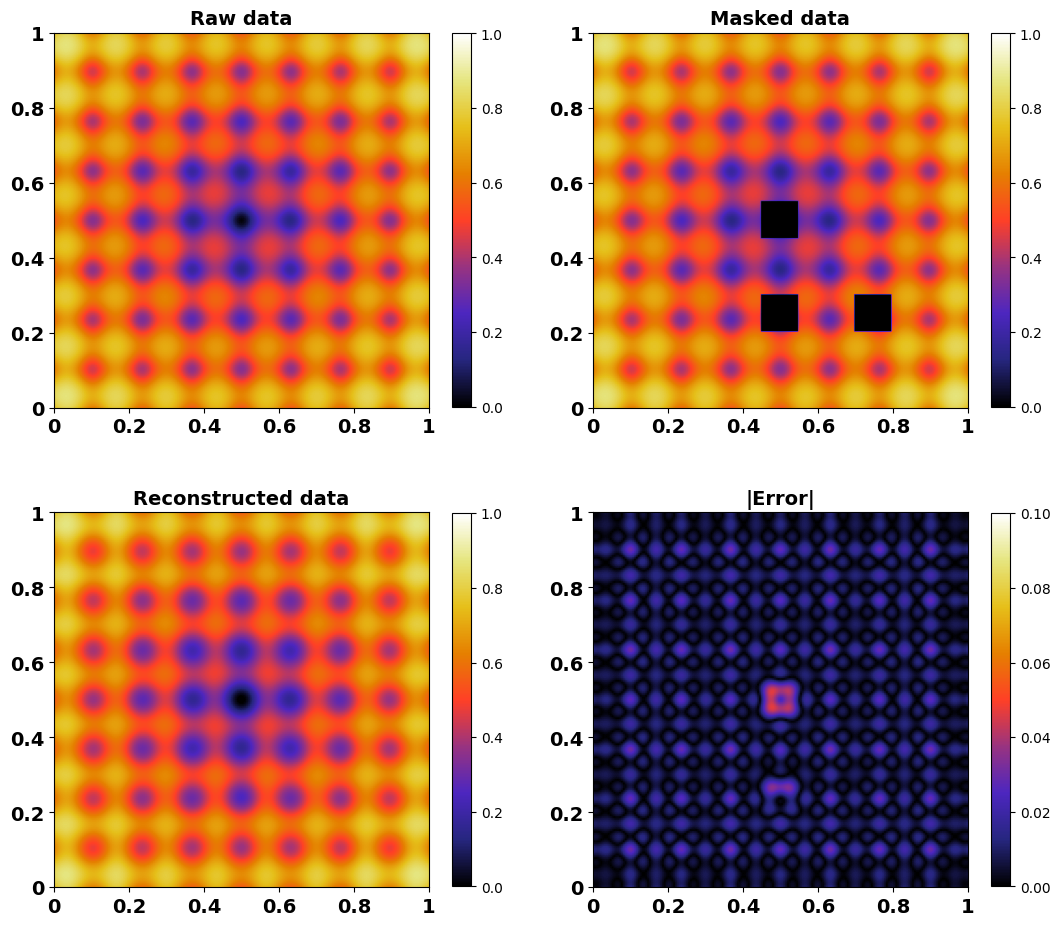

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm


# visualization
fig, axes = plt.subplots(2, 2, figsize=(13, 12))
fig.subplots_adjust(wspace=0.15, hspace=0.08)
for i in range(4):
    if i == 0:
        ax = axes[0, 0]
        im = ax.imshow(
            u3d[101, :, :], extent=[0, 1, 0, 1], cmap=cm.CMRmap, vmin=0, vmax=1
        )
        ax.set_title("Raw data", fontsize=14, weight="bold")
        cbar = plt.colorbar(im, ax=ax, shrink=0.84)
    elif i == 1:
        ax = axes[0, 1]
        im = ax.imshow(
            u3d_mask[101, :, :], extent=[0, 1, 0, 1], cmap=cm.CMRmap, vmin=0, vmax=1
        )
        ax.set_title("Masked data", fontsize=14, weight="bold")
        cbar = plt.colorbar(im, ax=ax, shrink=0.84)
    elif i == 2:
        ax = axes[1, 0]
        im = ax.imshow(
            recon[101, :, :], extent=[0, 1, 0, 1], cmap=cm.CMRmap, vmin=0, vmax=1
        )
        ax.set_title("Reconstructed data", fontsize=14, weight="bold")
        cbar = plt.colorbar(im, ax=ax, shrink=0.84)
    else:
        ax = axes[1, 1]
        im = ax.imshow(
            np.abs(recon[101, :, :] - u3d[101, :, :]),
            extent=[0, 1, 0, 1],
            cmap=cm.CMRmap,
            vmin=0,
            vmax=0.1,
        )
        ax.set_title("|Error|", fontsize=14, weight="bold")
        cbar = plt.colorbar(im, ax=ax, shrink=0.84)
    ax.set_xticks(
        ticks=[0, 0.2, 0.4, 0.6, 0.8, 1],
        labels=[0, 0.2, 0.4, 0.6, 0.8, 1],
        fontsize=14,
        weight="bold",
    )
    ax.set_yticks(
        ticks=[0, 0.2, 0.4, 0.6, 0.8, 1],
        labels=[0, 0.2, 0.4, 0.6, 0.8, 1],
        fontsize=14,
        weight="bold",
    )

### reconstruction at specific points


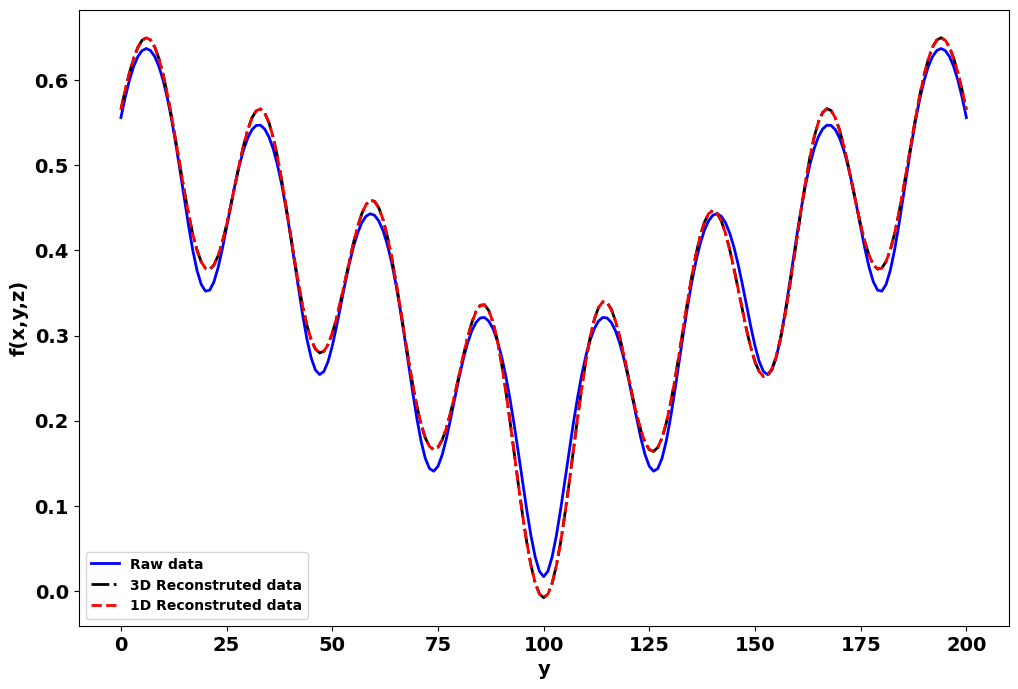

In [4]:
from mift.functions_3D import efficient_unstructured_IFFT_point

x = x3d[101, :, 101].flatten()
y = y3d[101, :, 101].flatten()
z = z3d[101, :, 101].flatten()
recon_points = efficient_unstructured_IFFT_point(
    coef, x, y, z, q * kx, q * ky, q * kz, Nx, Ny, Nz
)
plt.figure(figsize=(12, 8))
plt.plot(u3d[101, :, 101], "-b", label="Raw data", linewidth=2)
plt.plot(recon[101, :, 101], "-.k", label="3D Reconstruted data", linewidth=2)
plt.plot(recon_points, "--r", label="1D Reconstruted data", linewidth=2)
plt.legend(prop={"weight": "bold"}, loc="lower left")
plt.ylabel("f(x,y,z)", fontsize=14, fontweight="bold")
plt.xlabel("y", fontsize=14, fontweight="bold")
plt.xticks(fontsize=14, weight="bold")
plt.yticks(fontsize=14, weight="bold")
plt.show()